## Using option data
Group members: @ Vessi Li
@ Haolong Zhang
@ Chris Yan

***
The intent of this homework is to give you some practical experience working with options as well as practicing volatility forecasts and stock price simulations.

Your submission should be uploaded using a Jupyter notebook.  This is a group project so you can work with others or on your own.  I'm not setting up groups in Canvas so identify one person to submit for your group, make sure all names are on the submission, and I will take care of the rest.

Grades will be based on:

- Correctness of the submission (75%)
- Clarity of the comments, descriptions, and answers to the questions (25%)

***
Choose a company of your choice.

1. Download the data you need for the homework. Choose an expiration date near the end of December, like 12-20-24. I would recommend doing this after trading hours.
- Download the short term interest rate from the treasury department. Use the one month rate on the date your options are priced.
- Download the daily stock history for your stock from 01-01-2001 until the present.
- Anything else you think is necessary<br>

- Remove any options from your data that have zero open interest and where the last trade date is not the date of download. It is also reasonable to remove observations if the trade volume is low.

2. Calculate the implied volatilities for all options downloaded.  To do this, use the Black & Scholes equation.  Use the end of day price for the stock, the one-month interest rate, and calculate time to maturity in years.  Find the volatility that sets the B&S model price to the market price.  Make a plot and comment on the results.

3. For this question, we will simulate investing using stocks and options. Simulations will be done using historical return data.  For each instrument, including all call options and the stock, we will simulate investing $100 today and holding the position through maturity.
- You will conduct at least 1,000 simulations. Each simulation will consist of drawing one return from your historical return data for each trading day between now and then. You will use this data to estimate a stock price on April 19th.

- For each instrument, we want a table with three entries – average amount gained or lost, amount gained conditional on gains being positive, and the probability of having a positive gain. Make sure to include the original cash outlay in your calculations.

4. Try a variety of bull and bear spreads (https://www.investopedia.com/trading/options-strategies/Links to an external site.Links to an external site.) and redo question #3 to see if you can improve on the results from question #3. Explain when you might want to use a bull spread or a bear spread.



In [4]:
import yfinance as yf
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats as st
import wrds
import pandas_datareader.data as web
from scipy.optimize import minimize
from datetime import datetime
from scipy.optimize import brentq



Choose a company of your choice: AAPL

#### Step 1
1. Download the data you need for the homework. Choose an expiration date near the end of December, like 12-20-24. I would recommend doing this after trading hours.
- Download the short term interest rate from the treasury department. Use the one month rate on the date your options are priced.(-> Current Trading Day)
- Download the daily stock history for your stock from 01-01-2001 until the present.
- Anything else you think is necessary<br>

- Remove any options from your data that have zero open interest and where the last trade date is not the date of download. It is also reasonable to remove observations if the trade volume is low.



Method 2:WRDS

Go to https://wrds-www.wharton.upenn.eduLinks to an external site., click on register, for subscriber, choose Columbia University Libraries, for User type, choose students (Masters/Undergraduates), for Department, either enter School of Professional Studies or Enterprise Risk Management.  It will take two to three days to get access but they have significant historical data, as well as a lot of other data.

In [21]:
# Connect to WRDS
conn = wrds.Connection()


WRDS recommends setting up a .pgpass file.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done


Download the daily stock history for your stock from 01-01-2001 until the present.

In [22]:
#  WRDS
ticker = 'AAPL'
start_date = '2001-01-01'
end_date = pd.Timestamp.today().strftime('%Y-%m-%d')


query = f"""
SELECT a.date, a.prc AS closing_price, a.ret AS daily_return
FROM crsp.dsf AS a
JOIN crsp.stocknames AS b
ON a.permno = b.permno
WHERE b.ticker = '{ticker}'
AND a.date BETWEEN '{start_date}' AND '{end_date}'
ORDER BY a.date
"""  # Query CRSP for daily stock data

stock_data = conn.raw_sql(query)
print(stock_data.tail())


             date  closing_price  daily_return
11565  2023-12-27      193.14999      0.000518
11566  2023-12-28      193.58000      0.002226
11567  2023-12-28      193.58000      0.002226
11568  2023-12-29      192.53000     -0.005424
11569  2023-12-29      192.53000     -0.005424


The data from **WRDS** only goes up to 2023-12-29, because CRSP's update the daily stock data annually. In order to get the recent data, I turn to **Yahoo Finance** to access the daily stock prices from 01-01-2001 until the present.

Method 3: Market Data

You can get a temporary, free token from this website, www.marketdata.appLinks to an external site..  Then you install their extension into google sheets and you can use the option chain command, like this:  =OPTIONCHAIN("AAPL","all", "04/05/2024")

In [5]:
# read option and stock files
option_data = pd.read_csv("/Users/alukadawn/Desktop/Columbia/2024 Fall/QRM/Project 2 - Using option data/Project2Data - Optionchain.csv")
option_data.tail()


,Symbol,Underlying,Expiration Date,Option Side,Strike,First Traded,Days To Expiration,Date,Bid,Bid Size,...,In The Money,Intrinsic Value,Extrinsic Value,Underlying Price,IV,Delta,Gamma,Theta,Vega,Rho
133,AAPL241220P00325000,AAPL,12/20/2024,put,325,10/17/2024,42,11/8/2024,97.65,30,...,True,98.04,0.115,226.96,NaN,NaN,NaN,NaN,NaN,NaN
134,AAPL241220P00330000,AAPL,12/20/2024,put,330,7/10/2024,42,11/8/2024,102.65,50,...,True,103.04,0.115,226.96,NaN,NaN,NaN,NaN,NaN,NaN
135,AAPL241220P00335000,AAPL,12/20/2024,put,335,10/17/2024,42,11/8/2024,107.65,50,...,True,108.04,0.115,226.96,NaN,NaN,NaN,NaN,NaN,NaN
136,AAPL241220P00340000,AAPL,12/20/2024,put,340,7/10/2024,42,11/8/2024,112.65,50,...,True,113.04,0.115,226.96,NaN,NaN,NaN,NaN,NaN,NaN
137,AAPL241220P00350000,AAPL,12/20/2024,put,350,7/16/2024,42,11/8/2024,122.65,10,...,True,123.04,0.115,226.96,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
stock_data = pd.read_csv("/Users/alukadawn/Desktop/Columbia/2024 Fall/QRM/Project 2 - Using option data/Project2Data - Stock.csv")
stock_data.tail()

,Date,Open,High,Low,Close,Volume
5324,11/4/2024,220.990,222.790,219.710,222.01,40921729
5325,11/5/2024,221.795,223.950,221.140,223.45,27254038
5326,11/6/2024,222.610,226.065,221.190,222.72,51811157
5327,11/7/2024,224.625,227.875,224.570,227.48,40121817
5328,11/8/2024,227.170,228.660,226.405,226.96,36726907


Downloading the short term rate data

In [7]:
# short term rate data
start_date = '2023-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')
rate_data = web.DataReader("DGS1MO", "fred", start_date, end_date)
rate = rate_data.iloc[-1].values[0] / 100  # rate on pricing date

rate

0.047

Data Cleaning: Remove any options from your data that have zero open interest and where the last trade date is not the date of download. It is also reasonable to remove observations if the trade volume is low.

Since this method involves importing data from Google Sheets as .csv/.xlsx files, we opted to clean the data by retaining only actively traded options as of the download date (11/08/2024).

In [8]:
option_data_filtered = option_data.copy()

option_data_filtered = option_data_filtered[option_data_filtered['Open Interest'] > 0]

min_volume = option_data_filtered['Volume'].quantile(0.05) # remove the lower percentile volmue trade
option_data_filtered = option_data_filtered[option_data_filtered['Volume'] >= min_volume]

option_data_filtered.tail()


,Symbol,Underlying,Expiration Date,Option Side,Strike,First Traded,Days To Expiration,Date,Bid,Bid Size,...,In The Money,Intrinsic Value,Extrinsic Value,Underlying Price,IV,Delta,Gamma,Theta,Vega,Rho
119,AAPL241220P00255000,AAPL,12/20/2024,put,255,3/8/2023,42,11/8/2024,27.65,55,...,True,28.04,0.115,226.96,NaN,NaN,NaN,NaN,NaN,NaN
120,AAPL241220P00260000,AAPL,12/20/2024,put,260,3/8/2023,42,11/8/2024,32.65,14,...,True,33.04,0.090,226.96,NaN,NaN,NaN,NaN,NaN,NaN
122,AAPL241220P00270000,AAPL,12/20/2024,put,270,3/8/2023,42,11/8/2024,42.20,65,...,True,43.04,0.110,226.96,NaN,NaN,NaN,NaN,NaN,NaN
132,AAPL241220P00320000,AAPL,12/20/2024,put,320,6/14/2024,42,11/8/2024,92.65,50,...,True,93.04,0.115,226.96,NaN,NaN,NaN,NaN,NaN,NaN
137,AAPL241220P00350000,AAPL,12/20/2024,put,350,7/16/2024,42,11/8/2024,122.65,10,...,True,123.04,0.115,226.96,NaN,NaN,NaN,NaN,NaN,NaN


Setting up Black-Scholes calculation to calculate implied volatilities, downloading the short term rate data

In [9]:
# Black-Scholes d1 and d2 calculations
def d1(S, T, K, r, vol):
    return (np.log(S / K) + (r + vol**2 / 2) * T) / (vol * np.sqrt(T))

def d2(S, T, K, r, vol):
    return d1(S, T, K, r, vol) - vol * np.sqrt(T)

# Call option price calculation
def call_price(S, T, K, r, vol):
    if T == 0:
        return max(S - K, 0)
    else:
        return S * st.norm.cdf(d1(S, T, K, r, vol)) - K * np.exp(-r * T) * st.norm.cdf(d2(S, T, K, r, vol))

# Put option price calculation
def put_price(S, T, K, r, vol):
    if T == 0:
        return max(K - S, 0)
    else:
        return K * np.exp(-r * T) * st.norm.cdf(-d2(S, T, K, r, vol)) - S * st.norm.cdf(-d1(S, T, K, r, vol))


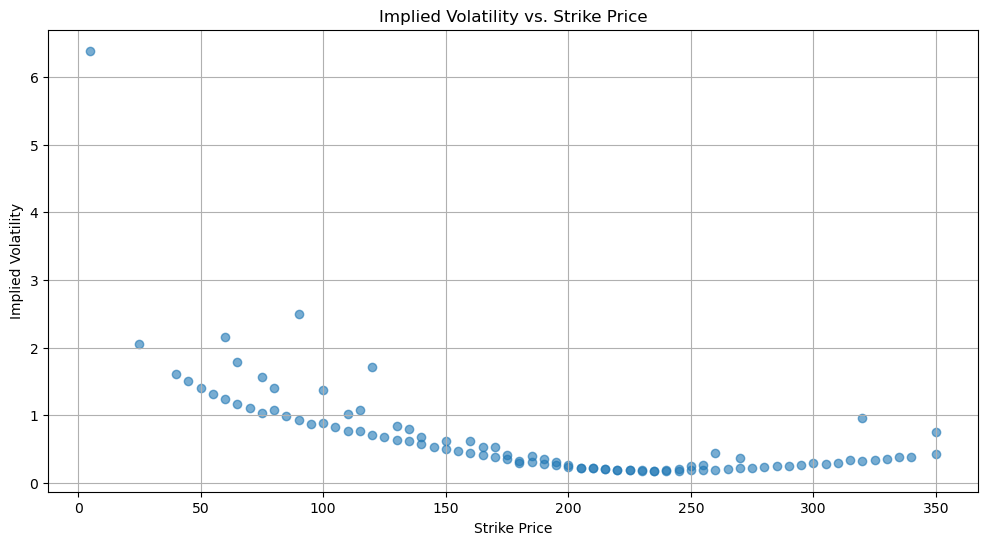

In [10]:
# "Reverse" the BS function to find a implied volatility that equates the BS opiton price to downloaded market price
def implied_volatility(S, K, T, r, market_price, option_type='call'):
    try:
        implied_vol = brentq(
            lambda vol: (call_price(S, T, K, r, vol) if option_type == 'call' else put_price(S, T, K, r, vol)) - market_price,
            1e-6, 10.0, maxiter=200  # find the appropriate implied vol from the range of 1e-6 to 10
        )
        return implied_vol
    except ValueError:
        return np.nan

S = stock_data['Close'].iloc[-1] 
r = rate

# Calculate the time to maturity in years to match BS calculation
option_data_filtered['Time to Maturity'] = option_data_filtered['Days To Expiration'] / 365

# Compute implied volatilities
option_data_filtered['Implied Volatility'] = option_data_filtered.apply(
    lambda row: implied_volatility(
        S,
        row['Strike'],
        row['Time to Maturity'],
        r,
        row['Last'],
        option_type=row['Option Side'].lower()
    ),
    axis=1
)

# Plot implied volatilities
plt.figure(figsize=(12, 6))
plt.scatter(option_data_filtered['Strike'], option_data_filtered['Implied Volatility'], alpha=0.6)
 # This will show a combined call/put option iv agaisnt strike, 
 # we will also illustrate the seperated call/put graph in the following.
plt.title('Implied Volatility vs. Strike Price')
plt.xlabel('Strike Price')
plt.ylabel('Implied Volatility')
plt.grid(True)
plt.show()


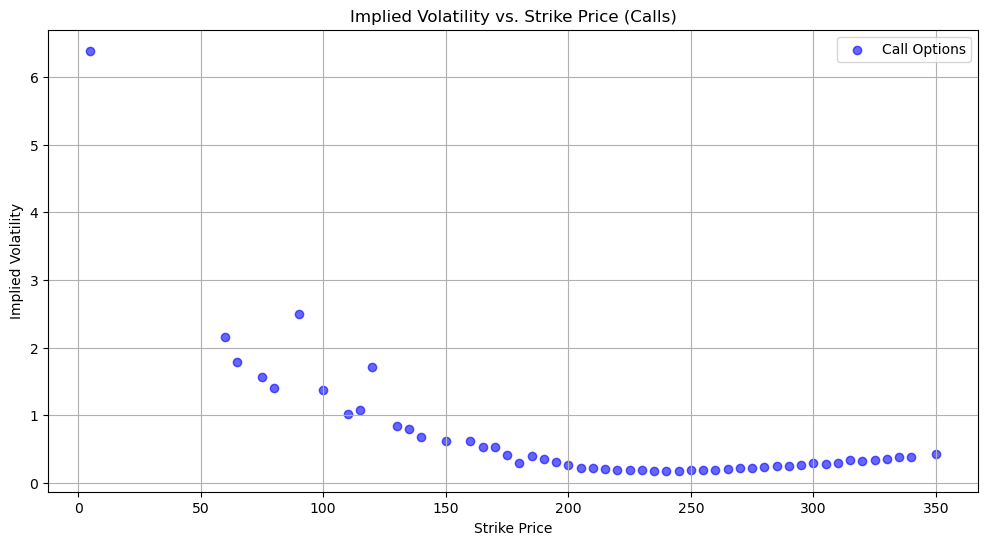

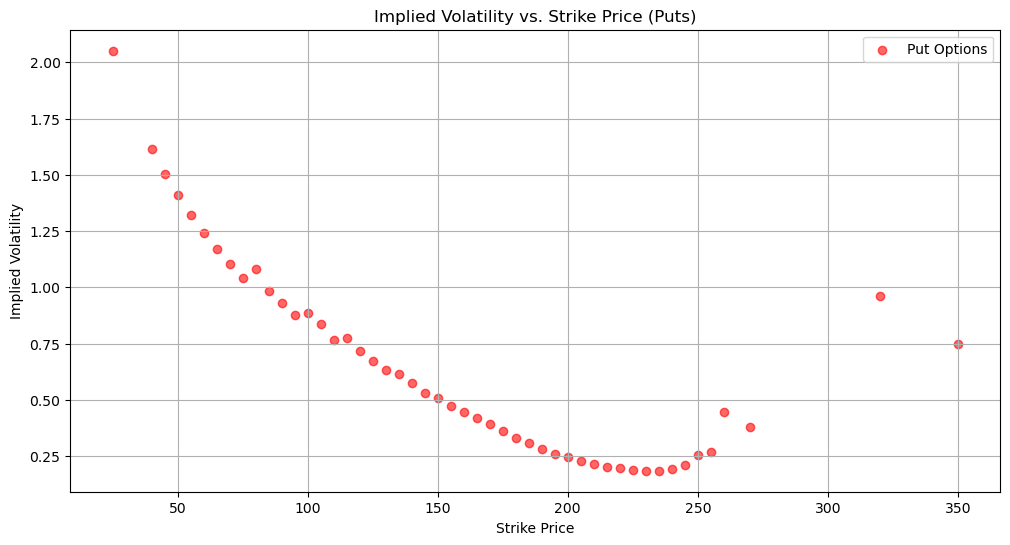

In [11]:
# Separate the options into calls and puts
call_options = option_data_filtered[option_data_filtered['Option Side'].str.lower() == 'call']
put_options = option_data_filtered[option_data_filtered['Option Side'].str.lower() == 'put']

# Plot implied volatilities for calls
plt.figure(figsize=(12, 6))
plt.scatter(call_options['Strike'], call_options['Implied Volatility'], color='blue', alpha=0.6, label='Call Options')
plt.title('Implied Volatility vs. Strike Price (Calls)')
plt.xlabel('Strike Price')
plt.ylabel('Implied Volatility')
plt.grid(True)
plt.legend()
plt.show()

# Plot implied volatilities for puts
plt.figure(figsize=(12, 6))
plt.scatter(put_options['Strike'], put_options['Implied Volatility'], color='red', alpha=0.6, label='Put Options')
plt.title('Implied Volatility vs. Strike Price (Puts)')
plt.xlabel('Strike Price')
plt.ylabel('Implied Volatility')
plt.grid(True)
plt.legend()
plt.show()


### Decision to Use Yahoo Finance (Method 1)

After evaluating both Method 2 (WRDS) and Method 3 (Market Data), we concluded that neither is optimal for this project for the following reasons:

- **Method 2 (WRDS)**:
  - The WRDS data (from CRSP) only covers up to 2023-12-29 due to their annual update schedule.
  - To obtain recent daily stock prices, an alternative source, like Yahoo Finance, is needed to cover the period from 01-01-2001 to the present.

- **Method 3 (Market Data)**:
  - Market Data requires up-to-date .csv/.xlsx files, which must be manually imported.
  - This reliance on Market Data’s Google Sheets extension can be inconvenient, particularly for users without access to this extension.

For these reasons, we decided to use **Yahoo Finance** (Method 1) to access both stock and option data, as it offers a more efficient, up-to-date, and accessible solution for this project.


In [23]:
# Yahoo Finance：
ticker = "AAPL"
start_date = "2001-01-01"
end_date = pd.Timestamp.today().strftime('%Y-%m-%d')


stock_data = yf.download(ticker, start=start_date, end=end_date)
stock_data['Daily Return'] = stock_data['Adj Close'].pct_change()
stock_data = stock_data[['Adj Close', 'Daily Return']].rename(columns={'Adj Close': 'Closing Price'})

stock_data.reset_index(inplace=True)
# print(stock_data.tail())
stock_data.head()

[*********************100%***********************]  1 of 1 completed


,Date,Closing Price,Daily Return
0,2001-01-02,0.224067,NaN
1,2001-01-03,0.246663,0.100842
2,2001-01-04,0.257019,0.041985
3,2001-01-05,0.246663,-0.040293
4,2001-01-08,0.249487,0.011449


Download the short term interest rate from the treasury department. Use the one month rate on the date your options are priced.(-> Current Trading Day)

In [24]:
# short term rate data
start_date = '2023-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')
rate_data = web.DataReader("DGS1MO", "fred", start_date, end_date)
rate = rate_data.iloc[-1].values[0] / 100  # rate on pricing date

rate

0.047

Open Interest is the total number of outstanding option contracts at a given strike price and expiration date. It represents the number of active contracts that have not been closed or exercised.

To filter out options with zero open interest ensures that only actively traded options with open positions are included in the analysis.

Find the most recent trading date, Keep only rows where lastTradeDate matches the most recent trading date and reset index.


In [25]:
expiration_date_str = '2024-12-20'
expiration_date = datetime.strptime(expiration_date_str, '%Y-%m-%d').date() # keep date, remove time

stock = yf.Ticker(ticker)
options = stock.option_chain(expiration_date_str)

calls = options.calls[['lastPrice', 'strike', 'lastTradeDate', 'openInterest']].copy()
puts = options.puts[['lastPrice', 'strike', 'lastTradeDate', 'openInterest']].copy()
calls['OptionType'] = 'Call'
puts['OptionType'] = 'Put'
calls['lastTradeDate'] = pd.to_datetime(calls['lastTradeDate']).dt.date
puts['lastTradeDate'] = pd.to_datetime(puts['lastTradeDate']).dt.date # keep date, remove time


calls = calls[calls['openInterest'] > 0]
puts = puts[puts['openInterest'] > 0]
options_df = pd.concat([calls, puts], ignore_index=True)
options_df

most_recent_date = options_df['lastTradeDate'].max()



options_df2 = options_df[options_df['lastTradeDate'] == most_recent_date].reset_index(drop=True)
options_df2['Time to Maturity'] = options_df2['lastTradeDate'].apply(lambda x: (expiration_date - x).days / 365)
options_df2

,lastPrice,strike,lastTradeDate,openInterest,OptionType,Time to Maturity
0,100.79,125.0,2024-11-15,352,Call,0.09589
1,56.05,170.0,2024-11-15,4364,Call,0.09589
2,51.10,175.0,2024-11-15,4733,Call,0.09589
3,45.84,180.0,2024-11-15,8885,Call,0.09589
4,40.78,185.0,2024-11-15,7990,Call,0.09589
5,36.16,190.0,2024-11-15,20283,Call,0.09589
6,31.23,195.0,2024-11-15,9595,Call,0.09589
7,26.43,200.0,2024-11-15,14369,Call,0.09589
8,21.80,205.0,2024-11-15,4236,Call,0.09589
9,17.40,210.0,2024-11-15,9174,Call,0.09589


#### Step 2

Calculate the implied volatilities for all options downloaded. To do this, use the Black & Scholes equation. Use the end of day price for the stock, the one-month interest rate, and calculate time to maturity in years. Find the volatility that sets the B&S model price to the market price. Make a plot and comment on the results.

In [26]:
S_space = np.linspace(170, 270, 100)

def d1(S, T, K, r, vol):
    return (np.log(S/K) + (r+vol**2/2)*T)/vol/np.sqrt(T)

def d2(S, T, K, r, vol):
    return d1(S, T, K, r, vol) - vol*np.sqrt(T)

def call_price(S, T, K, r, vol):
    if T==0:
        return max(S-K, 0)
    else:
        return S*st.norm.cdf(d1(S, T, K, r, vol)) - K*np.exp(-r*T)*st.norm.cdf(d2(S, T, K, r, vol))

def put_price(S, T, K, r, vol):
    if T==0:
        return max(K-S, 0)
    else:
        return K*np.exp(-r*T)*st.norm.cdf(-d2(S, T, K, r, vol)) - S*st.norm.cdf(-d1(S, T, K, r, vol))

PriceDifference function is used to minimize the difference between market price and BS model price.

- I use the squared difference (call_price(S,T,K,r,vol)−market_price)^2 rather than the simple difference to ensure that positive and negative differences do not cancel each other out.

- I set up the bounds for implied vol to make sure it will not have negative value.

- 'lastPrice' is the cost to buy each call or put option. It represents the current market price (last traded price / bid price) of each option contract, not the underlying stock.

The optimizer sets result.success to True when further changes to the Volatility no longer significantly reduce the Squared Difference; When the optimizer couldn’t find a solution within the given parameters, the code returns np.nan.

In [27]:
r = rate
S = stock_data['Closing Price'].iloc[-1]

def implied_volatility(market_price, S, K, T, r, option_type):

    def PriceDifference(vol):
        if option_type == 'Call':
            return (call_price(S, T, K, r, vol) - market_price) ** 2
        elif option_type == 'Put':
            return (put_price(S, T, K, r, vol) - market_price) ** 2
    result = minimize(PriceDifference, r, bounds=[(0.0001, 3.0)])

    return result.x[0] if result.success else np.nan


options_df3 = options_df2.copy()
options_df3['Implied Volatility'] = options_df3.apply(
    lambda row: implied_volatility(row['lastPrice'], S, row['strike'], row['Time to Maturity'], r, row['OptionType']),
    axis=1
)
options_df3

,lastPrice,strike,lastTradeDate,openInterest,OptionType,Time to Maturity,Implied Volatility
0,100.79,125.0,2024-11-15,352,Call,0.09589,0.047000
1,56.05,170.0,2024-11-15,4364,Call,0.09589,0.047000
2,51.10,175.0,2024-11-15,4733,Call,0.09589,0.047000
3,45.84,180.0,2024-11-15,8885,Call,0.09589,0.047000
4,40.78,185.0,2024-11-15,7990,Call,0.09589,0.047000
5,36.16,190.0,2024-11-15,20283,Call,0.09589,0.047000
6,31.23,195.0,2024-11-15,9595,Call,0.09589,0.047000
7,26.43,200.0,2024-11-15,14369,Call,0.09589,0.047000
8,21.80,205.0,2024-11-15,4236,Call,0.09589,0.047000
9,17.40,210.0,2024-11-15,9174,Call,0.09589,0.245122


Apply Function implied_volatility to each row (when axis=1) to calculate the Implied Volatility for each option in options_df2 and storing it in options_df3 with a new column called 'Implied Volatility'.

Then plot implied volatility separately for calls and puts, along with the spot price as a reference.

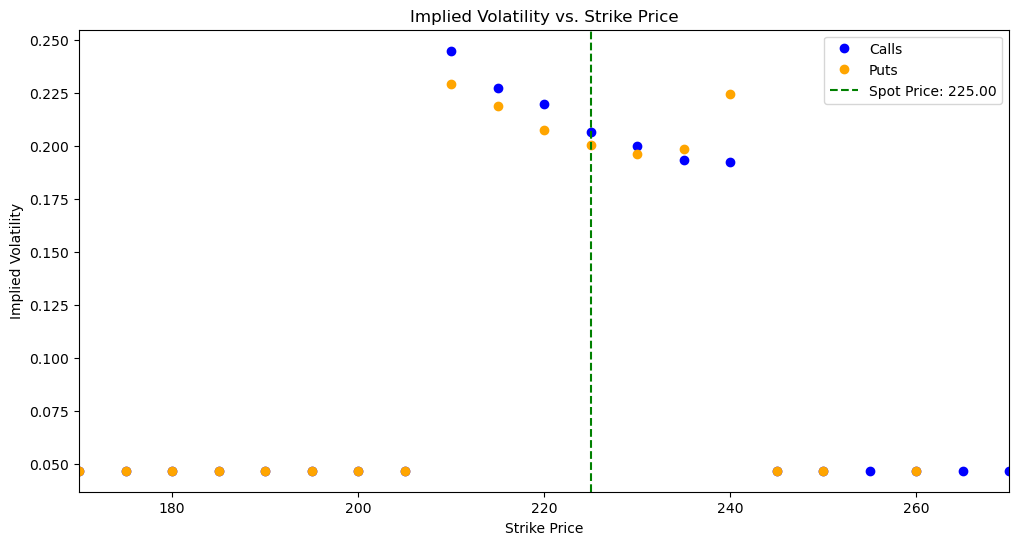

In [28]:
calls_df = options_df3[options_df2['OptionType'] == 'Call']
puts_df = options_df3[options_df2['OptionType'] == 'Put']


plt.figure(figsize=(12, 6))
plt.plot(calls_df['strike'], calls_df['Implied Volatility'], 'o', label='Calls', color='blue')
plt.plot(puts_df['strike'], puts_df['Implied Volatility'], 'o', label='Puts', color='orange')
S_value = float(S)
plt.axvline(x=S_value, color='green', linestyle='--', label=f'Spot Price: {S_value:.2f}')

plt.xlabel('Strike Price')
plt.ylabel('Implied Volatility')
plt.title('Implied Volatility vs. Strike Price')
plt.xlim(170, 270)
plt.legend()
plt.show()

Answer:

We can observe a U-shaped pattern in implied volatility, especially for puts. Since these options expire in about one month, they are considered short-dated options. The pattern is more of a smile than a negative skew, though a skew may be observed depending on the quality of the data.

Comment on the results:

- Implied Volatility Skew/Smile:
Options that are further "out of the money" tend to have higher implied volatilities, reflecting the increased uncertainty in extreme market movements.

- Higher Volatility for OTM Puts: OTM puts have higher implied volatilities than calls. it aligns with the market’s typical demand for downside protection, as puts serve as protective instruments in bearish markets. Investors are often more concerned with sharp drops in stock prices than with extreme upward movements. This leads to higher demand for protective puts, driving up their implied volatility.

- Near-ATM Volatilities: ATM options should have the lowest implied volatility, as they are less sensitive to directional market moves compared to deep ITM or OTM options. ATM options are primarily sensitive to changes in volatility (ATM options have the highest vega, but lower volga), which can result in a more stable implied volatility around the ATM strike.

- Low Implied Volatility at Extremes:
Low implied volatilities at extreme strike prices can result from low or **no trading activity** in those options. When an option has minimal trading, there are fewer data points to estimate an accurate implied volatility.

- Put-Call Parity: Theoretically, implied volatilities of calls and puts with the same strike and expiration should be nearly equal in an efficient market due to put-call parity. However, slight differences may arise due to supply and demand imbalances or slight arbitrage opportunities.


<span style="color:grey">

Below, I plot the vega and volga for calls and puts. While not required by the project, these plots serve as a complement to help explain the behavior of implied volatility.

ATM options have high Vega because they are most sensitive to changes in implied volatility, even though their implied volatility is relatively low.<br>
This low ATM implied volatility results from supply/demand dynamics and lower perceived risk near the current price, whereas high IV at the wings reflects greater demand for tail-risk hedging.<br>

Vega
- Vega measures the sensitivity of an option's price to changes in implied volatility.
- From the vega plot, we can observe that the vega is highest around the ATM strike price. At-the-money option prices are more affected by shifts in implied volatility.
- It helps explain why implied volatility is often more stable for strikes further away from ATM. When the market expects high volatility, it has a larger effect on the ATM options’ prices, which often leads to the characteristic smile or skew shape of the implied volatility curve.

Volga
- Volga measures the sensitivity of vega to changes in volatility.
- The volga plot typically shows higher values for options further from the ATM strike price, especially for short-dated options.
- This behavior of volga helps explain why the implied volatility curve tends to steepen in highly volatile markets. Since OTM options have higher volga, they adjust more to shifts in volatility expectations, often leading to steeper implied volatility skews or smiles, particularly when the market anticipates extreme movements.

Together, these sensitivities help explain why implied volatility curves often have a U-shape (smile) or skew, reflecting market expectations about future price movements.
</SPAN>

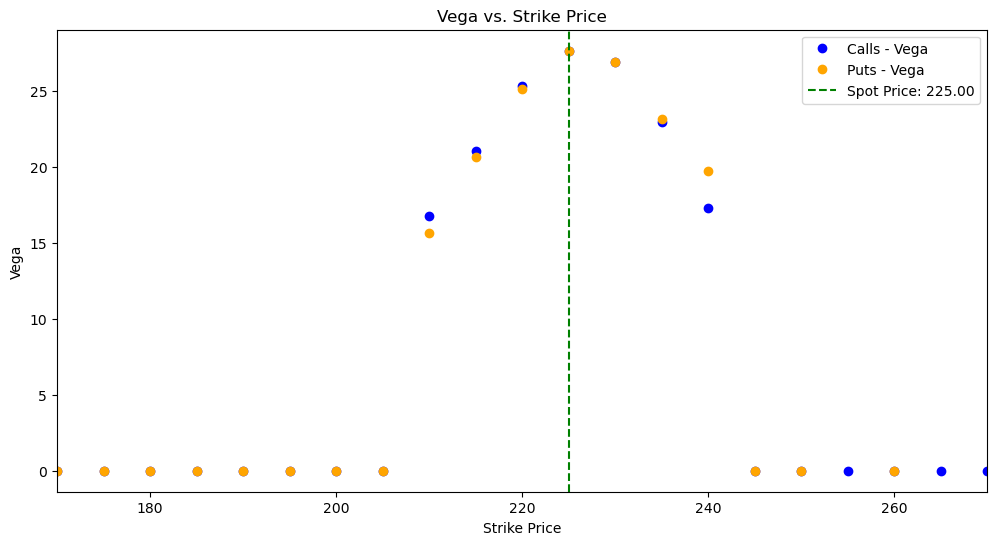

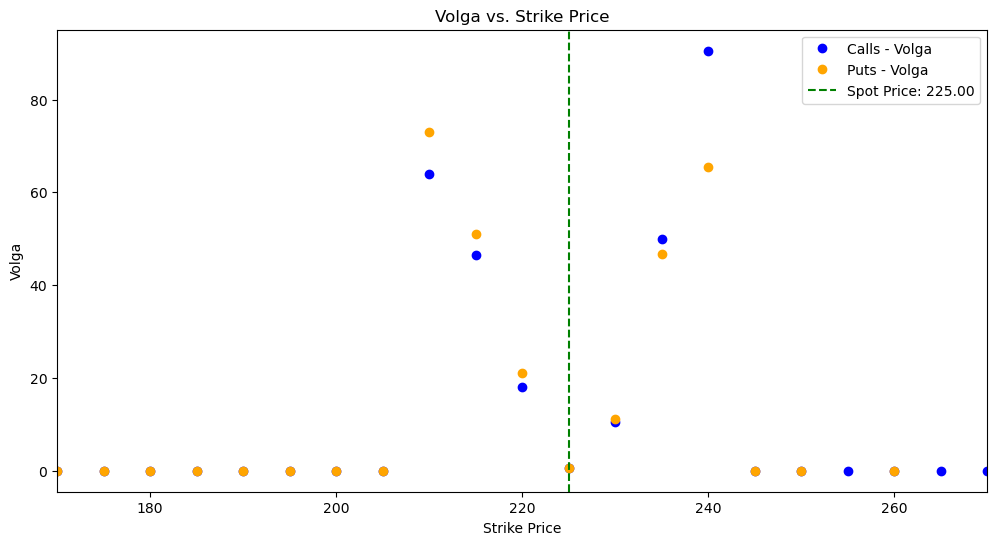

In [8]:
def vega(S, T, K, r, vol):
    d1_val = d1(S, T, K, r, vol)
    return S * np.sqrt(T) * st.norm.pdf(d1_val)

def volga(S, T, K, r, vol):
    d1_val = d1(S, T, K, r, vol)
    d2_val = d2(S, T, K, r, vol)
    return S * np.sqrt(T) * st.norm.pdf(d1_val) * d1_val * d2_val / vol


calls_vega = [vega(S, row['Time to Maturity'], row['strike'], r, row['Implied Volatility']) for _, row in calls_df.iterrows()]
puts_vega = [vega(S, row['Time to Maturity'], row['strike'], r, row['Implied Volatility']) for _, row in puts_df.iterrows()]
calls_volga = [volga(S, row['Time to Maturity'], row['strike'], r, row['Implied Volatility']) for _, row in calls_df.iterrows()]
puts_volga = [volga(S, row['Time to Maturity'], row['strike'], r, row['Implied Volatility']) for _, row in puts_df.iterrows()]

# Vega
plt.figure(figsize=(12, 6))
plt.plot(calls_df['strike'], calls_vega, 'o', label='Calls - Vega', color='blue')
plt.plot(puts_df['strike'], puts_vega, 'o', label='Puts - Vega', color='orange')
S_value = float(S)
plt.axvline(x=S_value, color='green', linestyle='--', label=f'Spot Price: {S_value:.2f}')
plt.xlabel('Strike Price')
plt.ylabel('Vega')
plt.title('Vega vs. Strike Price')
plt.xlim(170, 270)
plt.legend()
plt.show()

# Volga
plt.figure(figsize=(12, 6))
plt.plot(calls_df['strike'], calls_volga, 'o', label='Calls - Volga', color='blue')
plt.plot(puts_df['strike'], puts_volga, 'o', label='Puts - Volga', color='orange')
plt.axvline(x=S_value, color='green', linestyle='--', label=f'Spot Price: {S_value:.2f}')
plt.xlabel('Strike Price')
plt.ylabel('Volga')
plt.title('Volga vs. Strike Price')
plt.xlim(170, 270)
plt.legend()
plt.show()


#### Step 3
For this question, we will simulate investing using stocks and options. Simulations will be done using historical return data.  For each instrument, including all call options and the stock, we will simulate investing $100 today and holding the position through maturity.

- You will conduct at least 1,000 simulations. Each simulation will consist of drawing one return from your historical return data for each trading day between now and then. You will use this data to estimate a stock price on 12/20/24.

- For each instrument, we want a table with three entries – average amount gained or lost, amount gained conditional on gains being positive, and the probability of having a positive gain. Make sure to include the original cash outlay in your calculations.


In [29]:
start_date = pd.Timestamp.today().normalize()  # Today's date
end_date = pd.Timestamp('2024-12-20')
trading_days = np.busday_count(start_date.date(), end_date.date())
print(f"Number of trading days from {start_date.date()} to {end_date.date()}: {trading_days}")


stock_data_cleaned = stock_data.dropna()
#print(stock_data_cleaned.count())
stock_data_cleaned.head()

Number of trading days from 2024-11-16 to 2024-12-20: 24


,Date,Closing Price,Daily Return
1,2001-01-03,0.246663,0.100842
2,2001-01-04,0.257019,0.041985
3,2001-01-05,0.246663,-0.040293
4,2001-01-08,0.249487,0.011449
5,2001-01-09,0.258901,0.037737


Explaination:

- invest $100 in stocks and invest $100 in options.

- Calculate the number of trading days from today to maturity date 2024-12-20.

- Download the daily stock history from 01-01-2001 until the present, and drop any NaN values, and store the result in stock_data_cleaned.

- Create an empirical distribution using historical data, assuming returns are drawn from actual daily returns rather than a log-normal distribution.

- Randomly pulling number of trading days of returns from the dataset stock_data_cleaned (around 6000 return potentials), and store in simulated_returns.

- Calculate the cumulative return for each simulation, then calculate the simulated stock price at maturity 12-20-2024.

$$
\text{Final Investment Value} = \left( \frac{\text{Simulated Stock Price at Maturity (12-20-2024)}}{\text{Today's Stock Close Price}} \right) \times 100
$$


In [30]:
initial_investment = 100
num_simulations = 1000

ending_stock_prices = []

for _ in range(num_simulations):
    simulated_returns = stock_data_cleaned['Daily Return'].sample(n=trading_days, replace=True).values
    cumulative_return = np.prod(1 + simulated_returns)  # Compound each daily return
    ending_price = stock_data_cleaned['Closing Price'].iloc[-1] * cumulative_return
    ending_stock_prices.append(ending_price)

simulated_stock_prices_df = pd.DataFrame(ending_stock_prices, columns=['Ending Stock Price'])
simulated_stock_prices_df['Final Stock Value'] = (simulated_stock_prices_df['Ending Stock Price'] / stock_data_cleaned['Closing Price'].iloc[-1]) * initial_investment
simulated_stock_prices_df['Gain/Loss'] = simulated_stock_prices_df['Final Stock Value'] - initial_investment

print("\nSummary of Final Stock Values:")
print(simulated_stock_prices_df['Final Stock Value'].describe())
simulated_stock_prices_df.tail()



Summary of Final Stock Values:
count    1000.000000
mean      103.202848
std        10.983320
min        72.740886
25%        95.560878
50%       102.633812
75%       110.104647
max       150.117519
Name: Final Stock Value, dtype: float64


,Ending Stock Price,Final Stock Value,Gain/Loss
995,246.468058,109.541359,9.541359
996,223.541775,99.351900,-0.648100
997,211.645572,94.064699,-5.935301
998,224.735577,99.882479,-0.117521
999,205.444738,91.308772,-8.691228


Calculate gain/loss for each option based on simulated stock prices at maturity.
- 'lastPrice' is the initial purchase price, because it's the price to buy one option contract (100 shares of the underlying stock).
- Calculate the payoff at maturity based on option type.
- Calculate the gain/loss relative to the initial purchase price

For each instrument, we want a table with three entries – average amount gained or lost, amount gained conditional on gains being positive, and the probability of having a positive gain. Make sure to include the original cash outlay in your calculations.

In [31]:
option_simulations = []
initial_investment = 100

for index, row in options_df3.iterrows():
    K = row['strike']
    option_type = row['OptionType']
    initial_option_price = row['lastPrice']  # Purchase price of the option
    gains_losses = []
    gains_losses_new = []

    contract_number = initial_investment / initial_option_price # 100/last price

    for ending_price in simulated_stock_prices_df['Ending Stock Price']:

        if option_type == 'Call':
            payoff = max(ending_price - K, 0)
        elif option_type == 'Put':
            payoff = max(K - ending_price, 0)

        final_option_value = payoff
        gain_loss = final_option_value - initial_option_price # payoff - premium
        gain_loss_new = contract_number * gain_loss
        #assume initial investment is $100
        ### contract_number = 100 / lastprice
        ### gain_loss_new = contract_number * gain_loss
        #contract_number = 100 / row['lastPrice']
        #gain_loss_new = contract_number * gain_loss
        gains_losses.append(gain_loss)
        gains_losses_new.append(gain_loss_new)

    gains_losses_df = pd.DataFrame(gains_losses, columns=['Gain/Loss'])
    gains_losses_new_df = pd.DataFrame(gains_losses_new, columns=['Gain/Loss_New'])


    # Calculate required statistics
    # 1) average amount gained or lost,
    # 2) amount gained conditional on gains being positive,
    # 3) the probability of having a positive gain.
    avg_gain_loss = gains_losses_df['Gain/Loss'].mean()
    avg_gain_conditional = gains_losses_df[gains_losses_df['Gain/Loss'] > 0]['Gain/Loss'].mean()
    positive_gains_count = (gains_losses_df['Gain/Loss'] > 0).sum()
    total_count = len(gains_losses_df)
    prob_positive_gain = positive_gains_count / total_count
    #original: prob_positive_gain = (gains_losses_df['Gain/Loss'] > 0).mean() #### 改 正的/总的

    # Calculate adjusted statistics with contract number applied
    avg_gain_loss_new = gains_losses_new_df['Gain/Loss_New'].mean()
    avg_gain_conditional_new = gains_losses_new_df[gains_losses_new_df['Gain/Loss_New'] > 0]['Gain/Loss_New'].mean()

    # Calculate the probability of a positive gain as the ratio of positive gains to total gains
    positive_gains_new_count = (gains_losses_new_df['Gain/Loss_New'] > 0).sum()  # positive counts
    total_new_count = len(gains_losses_new_df)
    prob_positive_gain_new = positive_gains_new_count / total_new_count


    option_simulations.append({
        'Strike Price': K,
        'Option Type': option_type,
        'Initial Option Price': initial_option_price,
        'Avg Gain/Loss': avg_gain_loss,
        'Avg Gain Conditional': avg_gain_conditional,
        'Probability Positive Gain': prob_positive_gain,
        'Avg Gain/Loss (Adjusted)': avg_gain_loss_new,
        'Avg Gain Conditional (Adjusted)': avg_gain_conditional_new,
        'Probability Positive Gain (Adjusted)': prob_positive_gain_new
    })

option_simulation_results = pd.DataFrame(option_simulations)
print("\nOption Gain/Loss Simulation Results:")
option_simulation_results




Option Gain/Loss Simulation Results:


,Strike Price,Option Type,Initial Option Price,Avg Gain/Loss,Avg Gain Conditional,Probability Positive Gain,Avg Gain/Loss (Adjusted),Avg Gain Conditional (Adjusted),Probability Positive Gain (Adjusted)
0,125.0,Call,100.79,6.416407,23.041323,0.568,6.366115,22.860723,0.568
1,170.0,Call,56.05,6.168737,23.107912,0.560,11.005776,41.227319,0.560
2,175.0,Call,51.10,6.134247,23.057912,0.560,12.004398,45.123116,0.560
3,180.0,Call,45.84,6.426530,23.031911,0.567,14.019481,50.244134,0.567
4,185.0,Call,40.78,6.542273,23.051323,0.568,16.042847,56.526050,0.568
5,190.0,Call,36.16,6.270356,23.039068,0.559,17.340587,63.714236,0.559
6,195.0,Call,31.23,6.392375,23.010251,0.558,20.468700,73.679957,0.558
7,200.0,Call,26.43,6.494766,22.892867,0.556,24.573464,86.616975,0.556
8,205.0,Call,21.80,6.630341,22.770779,0.550,30.414410,104.453113,0.550
9,210.0,Call,17.40,6.812500,22.544448,0.541,39.152298,129.565794,0.541


The last three columns (7, 8, 9) represent the adjusted data, calculated based on **an initial investment of $100.** The middle three columns (4, 5, 6) are based on calculations assuming **one contract was traded** for the corresponding option.

Calculate required statistics
1) average amount gained or lost: This is the average gain or loss across all 1,000 simulations, showing the expected return after including the initial cash outlay (the option price).
2) amount gained conditional on gains being positive: This is the average gain, but only for simulations where there was a positive return. This is especially relevant for options, as they often expire worthless.
3) the probability of having a positive gain: This is the percentage of simulations where the option ended with a profit, giving the likelihood of a positive outcome.

In each simulation, I draw returns for the exact number of trading days until expiration. This gives me a distribution of potential stock prices at maturity.

For the call price: If the stock is below strike price, it's zero. It's above, the payoff is the difference between the stock price and the strike price.




#### Step 4
Try a variety of bull and bear spreads (https://www.investopedia.com/trading/options-strategies/ Links to an external site.Links to an external site.) and redo question #3 to see if you can improve on the results from question #3. Explain when you might want to use a bull spread or a bear spread.

There are 4 spread strategies:

1. Bull Call Spread
- **Strategy**: Buy a call at a lower strike, Sell a call at a higher strike.

2. Bull Put Spread
- **Strategy**: Buy a put at a lower strike; Sell a put at a higher strike.

3. Bear Call Spread
- **Strategy**: Sell a call at a lower strike, Buy a call at a higher strike.

4. Bear Put Spread
- **Strategy**: Buy a put at a higher strike, Sell a put at a lower strike.

We expect that from now until December, the market is more likely to move up, so we rule out bear spread strategies first. Although bull put spreads provide an initial credit, they primarily profit from stability or slight increases, whereas a bull call spread better captures the upside potential. We are willing to accept limited upside profit in exchange for reduced upfront costs, so we decided to use a bull call spread for our step 4 instead of other spreads.

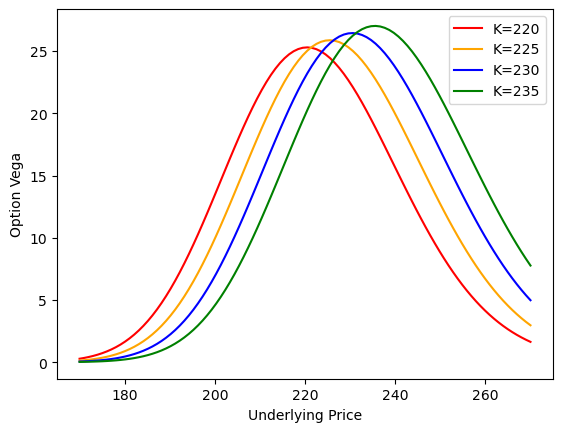

In [19]:
def vega(S, T, K, r, vol):
    return S*st.norm.pdf(d1(S, T, K, r, vol))*np.sqrt(T)
plt.plot(S_space, [vega(S, T=1/12, K=220, r=0.02, vol=0.3) for S in S_space], color='red', label='K=220')
plt.plot(S_space, [vega(S, T=1/12, K=225, r=0.02, vol=0.3) for S in S_space], color='orange', label='K=225')
plt.plot(S_space, [vega(S, T=1/12, K=230, r=0.02, vol=0.3) for S in S_space], color='blue', label='K=230')
plt.plot(S_space, [vega(S, T=1/12, K=235, r=0.02, vol=0.3) for S in S_space], color='green', label='K=235')
plt.legend()
_ = plt.xlabel('Underlying Price')
_ = plt.ylabel('Option Vega')

#### **Why we believe we want to use a bull spread:**

Our assumption: 
- We expect the underlying asset's price to increase, but not significantly above the $250. So I will long bull call spread to get exposure to the upside but at a cheaper cost.
- Strike prices are filtered within the range of 200 to 250.
- For simplicity, the spread is assumed to be 5 or 10.
- The bid and ask prices are assumed to be approximately equal to the last price.
- An initial investment of $100 is assumed.

**Bull call spread**: Buy a call option at a lower strike and sell a call at a higher strike. 

**I'm betting that volatility is cheap**. We can refer to the plot of vega: <span style="color:blue">If implied volatility decreases, the price of the higher strike option (e.g. $250) will drop faster than the lower strike (e.g. $240), benefiting my short position on the 250 strike. </SPAN> Since I'm long the lower strike and short the higher strike, the spread (difference in their prices) may increase in my favor, allowing me to profit.

(OTM options are more sensitive to changes in implied volatility because their value depends heavily on the potential for large price movements to bring the option into the money.)

In [18]:
def bull_spread(S, K_buy, K_sell, initial_cost_buy, initial_cost_sell):
    payoff = max(S - K_buy, 0) - max(S - K_sell, 0)  # bull spread payoff
    initial_cost = initial_cost_buy - initial_cost_sell
    return payoff - initial_cost 


filtered_strikes = options_df3[(options_df3['strike'] >= 200) & (options_df3['strike'] <= 250)]['strike'].sort_values().unique()
spread_differences = [5, 10]
spread_results = []

# loop to create spread
for K_buy in filtered_strikes:
    for diff in spread_differences:
        K_sell = K_buy + diff
        
        if K_sell > 250:
            continue
        
        call_buy = options_df3[(options_df3['strike'] == K_buy) & (options_df3['OptionType'] == 'Call')]
        call_sell = options_df3[(options_df3['strike'] == K_sell) & (options_df3['OptionType'] == 'Call')]

        if call_buy.empty or call_sell.empty: #or put_buy.empty or put_sell.empty:
            continue

        call_initial_cost_buy = call_buy.iloc[0]['lastPrice']
        call_initial_cost_sell = call_sell.iloc[0]['lastPrice']
        bull_call_contracts = 100 / (call_initial_cost_buy - call_initial_cost_sell)

        def calculate_metrics(payoffs):
            avg_gain_loss = np.mean(payoffs)
            avg_gain_conditional = np.mean([p for p in payoffs if p > 0]) if any(p > 0 for p in payoffs) else 0
            prob_positive_gain = sum(p > 0 for p in payoffs) / len(payoffs)
            return avg_gain_loss, avg_gain_conditional, prob_positive_gain

        bull_call_payoffs = [
            bull_spread(S, K_buy, K_sell, call_initial_cost_buy, call_initial_cost_sell) * bull_call_contracts
            for S in simulated_stock_prices_df['Ending Stock Price']
        ]
        avg_bull_call, cond_bull_call, prob_bull_call = calculate_metrics(bull_call_payoffs)

        spread_results.append({
            'Strike Price for Buying': round(K_buy,2),
            'Strike Price for Selling': round(K_sell,2),
            'Spread Difference': round(diff,2),
            'Bull Call Avg Gain/Loss': round(avg_bull_call,2),
            'Bull Call Avg Gain (Conditional)': round(cond_bull_call,2),
            'Bull Call Probability Positive Gain': round(prob_bull_call,2)
        })

spread_results_df = pd.DataFrame(spread_results)
print("\nBull Call Spread Simulation Results (Strike Range 200 to 250):")
spread_results_df




Bull Call Spread Simulation Results (Strike Range 200 to 250):


,Strike Price for Buying,Strike Price for Selling,Spread Difference,Bull Call Avg Gain/Loss,Bull Call Avg Gain (Conditional),Bull Call Probability Positive Gain
0,200.0,205.0,5,-4.18,7.99,0.87
1,200.0,210.0,10,-4.45,10.62,0.82
2,205.0,210.0,5,-4.74,13.58,0.81
3,205.0,215.0,10,-6.91,15.31,0.76
4,210.0,215.0,5,-9.15,17.21,0.76
5,210.0,220.0,10,-5.89,25.99,0.71
6,215.0,220.0,5,-2.08,36.59,0.70
7,215.0,225.0,10,-1.29,43.33,0.66
8,220.0,225.0,5,-0.41,53.03,0.63
9,220.0,230.0,10,6.73,72.60,0.59


In [17]:
best_bull_call_spread = spread_results_df.loc[spread_results_df['Bull Call Avg Gain/Loss'].idxmax()] #idmax()

print("\nBest Bull Call Spread(Below)")
best_bull_call_spread


Best Bull Call Spread(Below)


Strike Price for Buying                 245.00
Strike Price for Selling                250.00
Spread Difference                         5.00
Bull Call Avg Gain/Loss                 339.22
Bull Call Avg Gain (Conditional)       1435.16
Bull Call Probability Positive Gain       0.29
Name: 18, dtype: float64

#### **If you can improve on the results from question #3**
If the goal is to balance risk and reward while expecting only a moderate price increase, bull call spreads improve results compared to plain vanilla calls. However, if the goal is to maximize returns in anticipation of significant price movement, plain vanilla calls perform better.

- Gain and Loss: The bull call spread reduces risk by limiting losses, but it also caps potential gains compared to plain vanilla calls.
- Profitability Probability: Bull call spreads have a slightly lower probability of positive returns but offer a controlled risk-return profile, making them favorable for cautious investors expecting moderate price increases.
- Conditional Gains: Plain vanilla calls are better for aggressive strategies targeting large price moves, while bull call spreads are more structured and cost-efficient for range-bound price expectations.

Bull call spreads improve results for risk-averse investors by reducing potential losses and providing a more stable probability of gains. The trade-off is the capped profit potential, which may not suit aggressive investors aiming for high returns; Plain vanilla calls outperform bull call spreads when the investor expects a significant price increase, as they provide uncapped gains at the cost of higher potential losses.

**Explain when you might want to use a bull spread or a bear spread**:

**Bull Spreads**: These strategies perform better when implied volatility is stable or low because volatility increases the option premiums you pay, which limits your profitability. Also, when volatility is low, traders are less fearful about the price going down, normally the market is in neutral to bullish view. This strategy is suitable when expecting a moderate increase in the stock price. We achieve a bull spread by buying a call at a lower strike price and selling a call at a higher strike price. The code calculates the payoff by simulating stock prices at expiration.

**Bear Spreads**: These strategies can benefit from higher implied volatility, especially when you are buying options (like in the Bear Put Spread), as the value of those options increases more with higher volatility. Also, when volatility is high, traders are very fearful about the price going down, normally the market is very volatile and in a bearish view. This strategy is suitable when expecting a moderate decrease in the stock price. We create a bear spread by buying a put at a higher strike price and selling a put at a lower strike price.